In [194]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
from sklearn.metrics import  mean_squared_error, r2_score

import statsmodels.api as sm

In [195]:
cal = pd.read_csv('calendar.csv.gz')
listd = pd.read_csv('listings.csv.gz')
lists = pd.read_csv('listings.csv')
revs = pd.read_csv('reviews.csv.gz')
nhood = pd.read_csv('neighbourhoods.csv')

In [196]:
# pd.set_option('display.max_colu?mns', 96)
pd.set_option('display.max_rows', 96)

In [197]:
#CLEANUP incoming dataframes

listd_drop_cols = ['scrape_id','last_scraped','experiences_offered','thumbnail_url','medium_url','xl_picture_url',\
                   'host_name','host_location','neighbourhood_group_cleansed','square_feet',\
                   'maximum_nights','is_business_travel_ready']

# listd_numc_cols
# listd_catz_cols

print(len(listd.columns), len(listd_drop_cols))
listd.drop(listd_drop_cols,axis=1,inplace=True )
print(len(listd.columns), len(listd_drop_cols))

96 12
84 12


# ALL TRANSFORMATIONS FUNCTIONS  : 

In [198]:
print(cal.date.min(),cal.date.max())
print(revs.date.min(),revs.date.max())
# print(lists.last_review.min(),lists.last_review.max())

2018-07-05 2019-07-04
2009-05-03 2018-07-05


In [199]:
# tmp=listd.copy() # Create a new copy of the existing dataframe otherwise it is only by reference
# tmp.head().T

In [200]:
def price_xform(dframe,colname):
    dframe[colname]=dframe[colname].str.replace('$','')
    dframe[colname]=dframe[colname].str.replace(',','')
    dframe[colname]=pd.to_numeric(dframe[colname])
#     return(dframe)

In [201]:
def cat_rename(dframe,colname,src,tgt):
    dframe[colname]=dframe[colname].str.replace(src,tgt)
#     dframe[colname]=dframe[colname].str.replace(',','')
#     dframe[colname]=pd.to_numeric(dframe[colname])
#     return(dframe)

In [202]:
def create_dummies(dframe,colname):
#     dfnew=dframe.copy()
    dframe=pd.get_dummies(data=dframe, columns=[colname])# create dummies and drop the parent column
    dframe.drop(columns=[dframe.columns[-1]],inplace=True) #dropped the last column from the add dummies
    return dframe

In [203]:
#Impute Null Rows based on the specified column
def impute_nullrows(dframe,colname):
    print(dframe[colname].isnull().sum())
    dftmp=dframe[~dframe[colname].isnull()]   # remove nulls from one column
    print(dftmp[colname].isnull().sum())
    return dftmp


# TRANSFORM ACTIONS

In [204]:
# Convert to Booleans
listd['host_is_superhost'] = listd.apply(lambda x:  x.host_is_superhost=='t', axis= 1)
listd['host_has_profile_pic'] = listd.apply(lambda x:  x.host_has_profile_pic=='t', axis= 1)
listd['host_identity_verified'] = listd.apply(lambda x:  x.host_identity_verified=='t', axis= 1)
listd['instant_bookable'] = listd.apply(lambda x:  x.instant_bookable=='t', axis= 1)

In [205]:
#Transform all the price columns to remove "$" and ","

price_xform(listd,'price')
price_xform(listd,'weekly_price')
price_xform(listd,'monthly_price')
price_xform(listd,'security_deposit')
price_xform(listd,'cleaning_fee')
price_xform(listd,'extra_people')

In [206]:
#Transform the room_type . to create a meaningful name and create dummies

cat_rename(listd,'room_type','Entire home/apt','full')
cat_rename(listd,'room_type','Private room','pvt')
cat_rename(listd,'room_type','Shared room','shared')

listd=create_dummies(listd,'room_type')
# listd=pd.get_dummies(data=listd, columns=['room_type'])  # create dummies and drop the parent column
# listd.drop(columns=[listd.columns[-1]],inplace=True)  #dropped the last column from the add dummies

In [207]:
#Transform the bed_type . to create a meaningful name and create dummies
listd['bed_type'] = listd.apply(lambda x: x.bed_type=='Real Bed', axis=1)

In [208]:
#Put a count on amenities,   IF it does not work, pick the most important feature
listd['amentcnt'] =   listd.apply(lambda x: len(x.amenities.split(",")), axis=1)

In [209]:
#!!! APPLY the same for the test data also
#Impute the to remove the rows with no zipcode.  !!! APPLY the same for the test data also
listd=listd[~listd['zipcode'].isnull()]   # remove nulls from one column




In [210]:
#Impute the null values with meaningful data

listd['cleaning_fee']=listd['cleaning_fee'].fillna(0)
listd['review_scores_cleanliness'] = listd['review_scores_cleanliness'].fillna(listd.review_scores_cleanliness.mean())

listd['review_scores_location'] = listd['review_scores_location'].fillna(listd.review_scores_location.mean())
listd['review_scores_value'] = listd['review_scores_value'].fillna(listd.review_scores_value.mean())




In [211]:
# mask1 = listd['minimum_nights']>7 
# mask2 = listd['minimum_nights']<=32
# maskmid=mask1 & mask2 
# maskmid = (listd['minimum_nights']>7) & (listd['minimum_nights']<=32)
# mask2
# maskmid
listd.loc[listd['minimum_nights']<=7,'min_night_stay'] = 'short'
listd.loc[(listd['minimum_nights']>7) & (listd['minimum_nights']<=32),'min_night_stay'] = 'mid'
listd.loc[listd['minimum_nights']>32,'min_night_stay'] = 'long'
listd=create_dummies(listd,'min_night_stay')

In [212]:
#Condensing the property_type to sub categories

listd.loc[listd['property_type']=='Apartment', 'ppt_condensed'] = 'apt'
listd.loc[listd['property_type']=='Condominium', 'ppt_condensed'] = 'apt'
listd.loc[listd['property_type']=='Guest suite', 'ppt_condensed'] = 'apt'
listd.loc[listd['property_type']=='Townhouse', 'ppt_condensed'] = 'apt'
listd.loc[listd['property_type']=='Guesthouse', 'ppt_condensed'] = 'apt'
listd.loc[listd['property_type']=='Tiny house', 'ppt_condensed'] = 'apt'
listd.loc[listd['property_type']=='Timeshare', 'ppt_condensed'] = 'apt'

listd.loc[listd['property_type']=='Serviced apartment', 'ppt_condensed'] = 'aptspl'
listd.loc[listd['property_type']=='Bed and breakfast', 'ppt_condensed'] = 'aptspl'
listd.loc[listd['property_type']=='Treehouse', 'ppt_condensed'] = 'aptspl'
listd.loc[listd['property_type']=='Cabin', 'ppt_condensed'] = 'aptspl'

listd.loc[listd['property_type']=='Bus', 'ppt_condensed'] = 'auto'
listd.loc[listd['property_type']=='Boat', 'ppt_condensed'] = 'auto'
listd.loc[listd['property_type']=='Camper/RV', 'ppt_condensed'] = 'auto'

listd.loc[listd['property_type']=='Hostel', 'ppt_condensed'] = 'hostel'

listd.loc[listd['property_type']=='Boutique hotel', 'ppt_condensed'] = 'hotel'
listd.loc[listd['property_type']=='Hotel', 'ppt_condensed'] = 'hotel'
listd.loc[listd['property_type']=='Resort', 'ppt_condensed'] = 'hotel'
listd.loc[listd['property_type']=='Aparthotel', 'ppt_condensed'] = 'hotel'

listd.loc[listd['property_type']=='House', 'ppt_condensed'] = 'house'
listd.loc[listd['property_type']=='Bungalow', 'ppt_condensed'] = 'house'
listd.loc[listd['property_type']=='Cottage', 'ppt_condensed'] = 'house'
listd.loc[listd['property_type']=='Villa', 'ppt_condensed'] = 'house'

listd.loc[listd['property_type']=='Other', 'ppt_condensed'] = 'other'

listd.loc[listd['property_type']=='Loft', 'ppt_condensed'] = 'room'

listd=create_dummies(listd,'ppt_condensed')

In [213]:
listd=create_dummies(listd,'zipcode')

In [214]:
#imputing some more missing values

listd['cleaning_fee'].fillna(0, inplace=True)
listd['beds'].fillna(0, inplace=True)
listd['bathrooms'].fillna(0, inplace=True)

In [215]:
# lreg_cols = ['price','weekly_price','cleaning_fee','accommodates','bedrooms','beds',\
#              'bathrooms','guests_included','zipcode']

listd_drop_cols2=['id', 'listing_url', 'name', 'summary', 'space', 'description',\
       'neighborhood_overview', 'notes', 'transit', 'access', 'interaction',\
       'house_rules', 'picture_url', 'host_id', 'host_url', 'host_since',\
       'host_about', 'host_response_time', 'host_response_rate',\
       'host_acceptance_rate', 'host_thumbnail_url',\
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',\
       'host_total_listings_count', 'host_verifications',\
       'host_has_profile_pic', 'street',\
       'neighbourhood', 'neighbourhood_cleansed', 'city', 'state',\
       'market', 'smart_location', 'country_code', 'country', 'latitude',\
       'longitude', 'is_location_exact', 'property_type',\
       'amenities',\
       'weekly_price', 'monthly_price', 'security_deposit',\
       'extra_people', 'minimum_nights', 'calendar_updated',\
       'has_availability', 'availability_30', 'availability_60',\
       'availability_90', 'availability_365', 'calendar_last_scraped',\
       'number_of_reviews', 'first_review', 'last_review',\
       'review_scores_rating', 'review_scores_accuracy',\
       'review_scores_cleanliness', 'review_scores_checkin',\
       'review_scores_communication', 'review_scores_location',\
       'review_scores_value', 'requires_license', 'license',\
       'jurisdiction_names', 'instant_bookable', 'cancellation_policy',\
       'require_guest_profile_picture', 'require_guest_phone_verification',\
       'calculated_host_listings_count', 'reviews_per_month']
# listd_drop_cols2=['property_type','minimum_nights']
listd.drop(listd_drop_cols2,axis=1,inplace=True )

In [216]:
listd.columns

Index(['host_is_superhost', 'host_identity_verified', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'price', 'cleaning_fee',
       'guests_included', 'room_type_full', 'room_type_pvt', 'amentcnt',
       'min_night_stay_long', 'min_night_stay_mid', 'ppt_condensed_apt',
       'ppt_condensed_aptspl', 'ppt_condensed_auto', 'ppt_condensed_hostel',
       'ppt_condensed_hotel', 'ppt_condensed_house', 'ppt_condensed_other',
       'zipcode_94014.0', 'zipcode_94015.0', 'zipcode_94102.0',
       'zipcode_94103.0', 'zipcode_94104.0', 'zipcode_94105.0',
       'zipcode_94107.0', 'zipcode_94108.0', 'zipcode_94109.0',
       'zipcode_94110.0', 'zipcode_94111.0', 'zipcode_94112.0',
       'zipcode_94114.0', 'zipcode_94115.0', 'zipcode_94116.0',
       'zipcode_94117.0', 'zipcode_94118.0', 'zipcode_94121.0',
       'zipcode_94122.0', 'zipcode_94123.0', 'zipcode_94124.0',
       'zipcode_94127.0', 'zipcode_94129.0', 'zipcode_94131.0',
       'zipcode_94132.0', 'zipcode_94133.0

In [217]:
listd.shape

(4669, 50)

# EXTRA BEGIN

In [239]:
dflreg.host_is_superhost.value_counts()

False    2646
True     2023
Name: host_is_superhost, dtype: int64

In [241]:
dflreg.host_is_superhost.value_counts()

0    2646
1    2023
Name: host_is_superhost, dtype: int64

In [240]:
dflreg['host_is_superhost'] = (dflreg['host_is_superhost'] == True).astype(int)

dflreg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4669 entries, 0 to 4692
Data columns (total 51 columns):
const                     4669 non-null float64
host_is_superhost         4669 non-null int64
host_identity_verified    4669 non-null bool
accommodates              4669 non-null int64
bathrooms                 4669 non-null float64
bedrooms                  4669 non-null int64
beds                      4669 non-null float64
bed_type                  4669 non-null bool
price                     4669 non-null float64
cleaning_fee              4669 non-null float64
guests_included           4669 non-null int64
room_type_full            4669 non-null uint8
room_type_pvt             4669 non-null uint8
amentcnt                  4669 non-null int64
min_night_stay_long       4669 non-null uint8
min_night_stay_mid        4669 non-null uint8
ppt_condensed_apt         4669 non-null uint8
ppt_condensed_aptspl      4669 non-null uint8
ppt_condensed_auto        4669 non-null uint8
ppt_condens

# EXTRA END

In [218]:
dfcorr=listd.corr()
# dfcorr.price.sort_values()


In [219]:
dfcorr.head()

,host_is_superhost,host_identity_verified,accommodates,bathrooms,bedrooms,beds,bed_type,price,cleaning_fee,guests_included,...,zipcode_94122.0,zipcode_94123.0,zipcode_94124.0,zipcode_94127.0,zipcode_94129.0,zipcode_94131.0,zipcode_94132.0,zipcode_94133.0,zipcode_94134.0,zipcode_94158.0
host_is_superhost,1.000000,0.175279,-0.066246,-0.073244,-0.068472,-0.093756,-0.021697,-0.013003,-0.035032,0.004400,...,0.047449,-0.008327,-0.000980,0.016222,-0.012798,0.017896,-0.016272,-0.024038,-0.011413,-0.018776
host_identity_verified,0.175279,1.000000,0.022881,0.037757,0.083777,0.009490,-0.020877,0.057496,0.062758,0.043328,...,-0.004123,-0.026080,0.009686,0.000057,0.010770,0.014712,-0.018414,-0.054392,-0.035066,-0.024679
accommodates,-0.066246,0.022881,1.000000,0.480117,0.769191,0.834543,0.071087,0.434465,0.549483,0.559105,...,0.009334,0.023442,-0.009602,0.008477,0.019520,0.012934,-0.023730,0.001014,0.027702,0.004085
bathrooms,-0.073244,0.037757,0.480117,1.000000,0.554560,0.493639,0.036346,0.334613,0.376771,0.285099,...,-0.020438,0.037669,-0.014356,0.025868,-0.006674,0.002485,0.021276,-0.040516,-0.012096,0.003848
bedrooms,-0.068472,0.083777,0.769191,0.554560,1.000000,0.730330,0.046203,0.434527,0.581186,0.520352,...,-0.003992,0.037804,-0.023596,0.021624,0.009492,0.034685,-0.015172,0.012337,0.007095,0.001438


In [220]:
dfcorr.price.sort_values()

room_type_pvt            -0.255959
zipcode_94112.0          -0.081166
ppt_condensed_hostel     -0.065111
zipcode_94124.0          -0.058205
zipcode_94122.0          -0.046702
zipcode_94132.0          -0.043868
zipcode_94102.0          -0.043633
zipcode_94134.0          -0.037803
min_night_stay_mid       -0.037199
zipcode_94111.0          -0.027050
ppt_condensed_hotel      -0.026284
zipcode_94110.0          -0.025305
ppt_condensed_apt        -0.024605
zipcode_94014.0          -0.022688
ppt_condensed_aptspl     -0.020042
zipcode_94127.0          -0.018272
zipcode_94116.0          -0.015017
ppt_condensed_auto       -0.014007
ppt_condensed_other      -0.013178
host_is_superhost        -0.013003
zipcode_94015.0          -0.009239
zipcode_94107.0           0.001773
zipcode_94108.0           0.002104
zipcode_94118.0           0.002555
zipcode_94105.0           0.002993
zipcode_94131.0           0.003971
zipcode_94129.0           0.004267
zipcode_94158.0           0.006018
zipcode_94103.0     

'''
lreg_cols_master = ['square_feet','weekly_price','cleaning_fee','accommodates','bedrooms','beds','bathrooms','guests_included','zipcode']
lreg_cols = ['price','weekly_price','cleaning_fee','accommodates','bedrooms','beds','bathrooms','guests_included','zipcode']
'''

In [245]:
dflreg = listd.copy()
dflreg = sm.add_constant(dflreg)

In [246]:
dflreg['host_is_superhost'] = (dflreg['host_is_superhost'] == True).astype(int)
dflreg['host_identity_verified'] = (dflreg['host_identity_verified'] == True).astype(int)
dflreg['bed_type'] = (dflreg['bed_type'] == True).astype(int)

In [247]:
dfscatter=dflreg.loc[:,'price':'guests_included']
dfscatter.head()

,price,cleaning_fee,guests_included
0,170.0,100.0,2
1,235.0,100.0,2
2,65.0,50.0,1
3,63.0,30.0,1
4,65.0,50.0,1


In [ ]:
pd.plotting.scatter_matrix(dfscatter,figsize=(15,10));

In [248]:
y=dflreg.price
X=dflreg.drop(['price'],axis=1)

In [249]:
X_chunk, X_test, y_chunk, y_test = train_test_split(X, y, test_size=0.20, random_state=47)
X_train, X_vald, y_train, y_vald = train_test_split(X_chunk, y_chunk, test_size=0.20, random_state=47)

In [250]:
X_train = X_chunk.copy()
y_train = y_chunk.copy()

In [251]:
print(X_train.shape, X_vald.shape, X_test.shape)
print(y_train.shape, y_vald.shape, y_test.shape)

(3735, 50) (747, 50) (934, 50)
(3735,) (747,) (934,)


In [252]:
lmodel = linear_model.LinearRegression()
lmodel.fit(X_train,y_train)
y_predsk = lmodel.predict(X_test)

In [253]:
print('Coefficients: \n', lmodel.coef_)

Coefficients: 
 [-1.02088874e-12  1.63632750e+01  1.61715344e+01  2.01002861e+01
  5.15291644e+01  4.74595818e+01 -8.81628513e+00 -8.09067627e+00
  6.89729370e-01  1.20963393e+00  6.41541190e+01  3.60197251e+01
 -1.26057117e-01  1.18488004e+02 -3.94820605e+01 -4.50832053e+01
 -5.98382312e+01 -9.06519069e+01 -9.83628877e+01 -1.11938285e+01
 -2.64162161e+01 -5.90616830e+01 -5.99132236e+01  3.26352224e+00
  5.27637096e+01  3.34237993e+01  3.60366441e+02  8.03810372e+01
 -3.71498264e+00  1.04820175e+02  8.02839971e+01 -2.06717414e+01
  9.57055520e+01 -5.94694917e+01  1.92640541e+01  4.40856791e+01
  2.75208535e+00  9.49041088e+00 -2.00110274e+01  1.95511695e+01
 -5.12263107e+01  7.67816976e+01 -6.89120709e+01 -4.29479377e+01
  6.18867248e+00 -1.24972282e+01 -6.63966297e+01  1.32668784e+02
 -6.87850612e+01  4.83632016e+01]


In [254]:
y_predsk.shape

(934,)

In [255]:
from sklearn.utils import check_array
import numpy as np
def mse_prop(y_true, y_pred): 


    return (np.mean(np.abs((y_true - y_pred)**2 / (y_true+1)**2  )) * 100) **0.5



In [256]:
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_predsk))
print("Variance squared error: %.2f" % r2_score(y_test, y_predsk))

print("MSE Proportion: %.2f" % mse_prop(y_test, y_predsk))

Mean squared error: 14620.11
Variance squared error: 0.56
MSE Proportion: 36.32


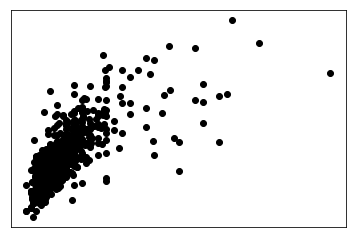

In [257]:
# Plot outputs
plt.scatter(y_test, y_predsk,  color='black')
#plt.plot(y_test, y_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

In [258]:
X_train.head().T

,4600,3946,3202,1757,3481
const,1.0,1.0,1.0,1.0,1.0
host_is_superhost,0.0,0.0,1.0,0.0,1.0
host_identity_verified,1.0,1.0,1.0,1.0,1.0
accommodates,2.0,3.0,4.0,2.0,6.0
bathrooms,1.0,1.0,1.0,2.0,3.0
bedrooms,0.0,2.0,1.0,1.0,4.0
beds,1.0,2.0,2.0,1.0,4.0
bed_type,1.0,1.0,1.0,1.0,1.0
cleaning_fee,15.0,65.0,70.0,75.0,500.0
guests_included,1.0,1.0,1.0,2.0,7.0


In [259]:
print( y_train.shape, X_train.shape)

(3735,) (3735, 50)


In [260]:
import statsmodels.api as sm
import numpy as np
model = sm.OLS(y_train, X_train)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.255
Model:                            OLS   Adj. R-squared:                  0.245
Method:                 Least Squares   F-statistic:                     25.71
Date:                Fri, 03 Aug 2018   Prob (F-statistic):          2.80e-196
Time:                        09:18:42   Log-Likelihood:                -25820.
No. Observations:                3735   AIC:                         5.174e+04
Df Residuals:                    3685   BIC:                         5.205e+04
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                    -42

447.4590861305329


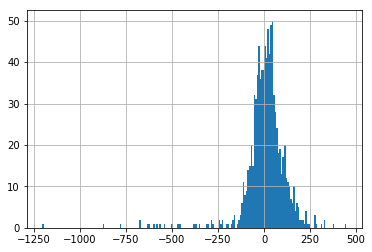

In [261]:
y_resdsk=(y_predsk-y_test)
print(y_resdsk.max())
y_resdsk.hist(bins =200)

9425.169346100553


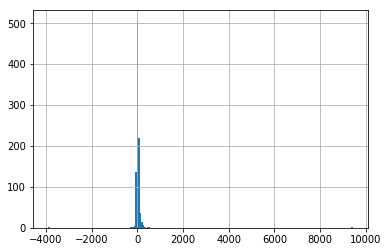

In [262]:
y_resdpct=(y_predsk-y_test)*100/(y_test+1)
print(y_resdpct.max())
y_resdpct.hist(bins =200)

In [263]:
dflreg.describe()

,const,host_is_superhost,host_identity_verified,accommodates,bathrooms,bedrooms,beds,bed_type,price,cleaning_fee,...,zipcode_94122.0,zipcode_94123.0,zipcode_94124.0,zipcode_94127.0,zipcode_94129.0,zipcode_94131.0,zipcode_94132.0,zipcode_94133.0,zipcode_94134.0,zipcode_94158.0
count,4669.0,4669.000000,4669.000000,4669.000000,4669.000000,4669.000000,4669.000000,4669.000000,4669.000000,4669.000000,...,4669.000000,4669.000000,4669.000000,4669.000000,4669.000000,4669.000000,4669.000000,4669.000000,4669.000000,4669.000000
mean,1.0,0.433283,0.648747,3.339473,1.285821,1.390019,1.828015,0.985650,217.754337,78.177982,...,0.048190,0.028272,0.021418,0.020133,0.000214,0.047548,0.010281,0.033626,0.016492,0.002570
std,0.0,0.495582,0.477413,1.995117,0.626862,0.940698,1.226746,0.118941,264.990406,67.459155,...,0.214191,0.165765,0.144788,0.140470,0.014635,0.212830,0.100881,0.180284,0.127371,0.050637
min,1.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,0.000000,0.000000,2.000000,1.000000,1.000000,1.000000,1.000000,100.000000,30.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.0,0.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,155.000000,65.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.0,1.000000,1.000000,4.000000,1.500000,2.000000,2.000000,1.000000,250.000000,100.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.0,1.000000,1.000000,16.000000,7.000000,7.000000,14.000000,1.000000,9000.000000,700.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


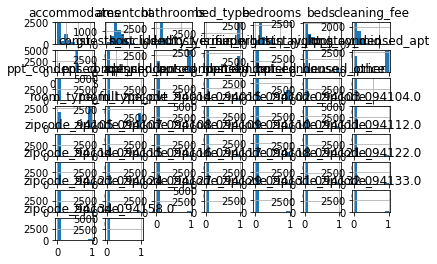

In [264]:
plt_cols = dflreg.columns
ax = dflreg[plt_cols].hist(bins=10)
plt.plot();

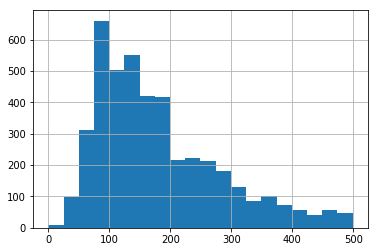

In [265]:
dflreg['price'][dflreg['price']<500].hist(bins=20);

In [267]:
dflreg['price'][[dflreg['price']>500 & dflreg['price']<2000]].hist(bins=20);

TypeError: cannot compare a dtyped [float64] array with a scalar of type [bool]

In [268]:
pd.crosstab(dflreg['bedrooms'], dflreg['beds'])

beds,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,10.0,12.0,14.0
bedrooms,,,,,,,,,,,,
0,5,317,128,8,3,0,0,0,0,0,0,0
1,30,2074,531,68,24,6,0,0,1,0,0,1
2,13,11,560,193,66,8,4,2,0,0,0,0
3,8,5,17,236,135,38,17,3,0,0,0,0
4,7,1,0,0,51,44,14,8,5,0,0,0
5,1,0,0,0,0,9,2,2,5,1,0,0
6,0,0,0,0,0,0,2,1,1,0,1,0
7,0,0,0,0,0,0,0,1,0,0,0,1


In [ ]:
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.metrics import accuracy_score, mean_squared_error
from collections import Counter

In [ ]:
myrfreg = 
myrfreg.fit(X, y)